# IDENTIFICAÇÃO DE FOGO EM IMAGENS UTILIZANDO TÉCNICAS DE CLASSIFICAÇÃO

Um problema de visão computacional que utiliza uma abordagem de aprendizado supervisionada para classificar imagens de acordo com a presença e ausência de fogo.

- **Descrição da base de dados:** A base de dados possui imagens com e sem fogo ao ar livre para tarefas de visão computacional. Ao todo são 999 imagens, onde 755 são de fogo ao ar livre podendo apresentar fumaça densa, e 244 não são de fogo e podem apresentar grama, estradas, árvores, florestas, lagos, rios, cachoeiras, animais e pessoas. 


- **Link da base de dados original:** https://www.kaggle.com/datasets/phylake1337/fire-dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# PREFIX_PATH='/content/'
PREFIX_PATH='/gdrive/MyDrive/Colab Notebooks/fire_image_classification/content/datasets/'
PREFIX_PATH_PRE_TRAINED_MODELS='/gdrive/MyDrive/Colab Notebooks/fire_image_classification/content/datasets/'

RESIZE_X = 100
RESIZE_Y = 100
CHANNEL = 3
FLATTEN_SHAPE = RESIZE_X * RESIZE_Y * CHANNEL
COLUMNS_PIXELS = ['pixel{}'.format(i) for i in range(0, FLATTEN_SHAPE)]

COLOR_HIST_RANGE = range(0, 256)
COLUMNS_HIST_B = ['hist_b_{}'.format(i) for i in COLOR_HIST_RANGE]
COLUMNS_HIST_G = ['hist_g_{}'.format(i) for i in COLOR_HIST_RANGE]
COLUMNS_HIST_R = ['hist_r_{}'.format(i) for i in COLOR_HIST_RANGE]
HIST_COLUMNS = COLUMNS_HIST_B + COLUMNS_HIST_G + COLUMNS_HIST_R

TOTAL_PIXELS_COLUMNS = FLATTEN_SHAPE + (256*3)

pixels_hist_columns = COLUMNS_PIXELS+COLUMNS_HIST_B+COLUMNS_HIST_G+COLUMNS_HIST_R
desc_columns = ['image_path', 'label', 'label_name', 'source_shape', 'source_height', 'source_width', 'source_channel']
COLUMNS_FULL_DF = desc_columns + pixels_hist_columns  

NOISES = ['gaussian', 'localvar', 'poisson', 'salt', 'pepper', 's&p', 'speckle']

LABEL_DATA = {0: (0, 'Sem fogo'), 1: (1, 'Com fogo')}

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import cv2
from google.colab.patches import cv2_imshow

import glob
import os

from sklearn.model_selection import train_test_split

import albumentations as A
import skimage
import random

# Praparando diretório para acessar API KEY da API do Kaggle para download da base de dados

Faça o upload do kaggle.json que contém sua API KEY

In [8]:
! cp '/content/kaggle.json' .

cp: '/content/kaggle.json' and './kaggle.json' are the same file


In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! kaggle datasets download -d phylake1337/fire-dataset

 96% 370M/387M [00:02<00:00, 202MB/s]
100% 387M/387M [00:02<00:00, 177MB/s]


In [11]:
! unzip fire-dataset.zip

Archive:  fire-dataset.zip
  inflating: fire_dataset/fire_images/fire.1.png  
  inflating: fire_dataset/fire_images/fire.10.png  
  inflating: fire_dataset/fire_images/fire.100.png  
  inflating: fire_dataset/fire_images/fire.101.png  
  inflating: fire_dataset/fire_images/fire.102.png  
  inflating: fire_dataset/fire_images/fire.103.png  
  inflating: fire_dataset/fire_images/fire.104.png  
  inflating: fire_dataset/fire_images/fire.105.png  
  inflating: fire_dataset/fire_images/fire.106.png  
  inflating: fire_dataset/fire_images/fire.107.png  
  inflating: fire_dataset/fire_images/fire.108.png  
  inflating: fire_dataset/fire_images/fire.109.png  
  inflating: fire_dataset/fire_images/fire.11.png  
  inflating: fire_dataset/fire_images/fire.110.png  
  inflating: fire_dataset/fire_images/fire.111.png  
  inflating: fire_dataset/fire_images/fire.112.png  
  inflating: fire_dataset/fire_images/fire.113.png  
  inflating: fire_dataset/fire_images/fire.114.png  
  inflating: fire_datas

# Carregamento inicial dos dados

In [4]:
! cd /content/fire_dataset

In [5]:
def get_image_attrs(image_path, label_tuple):
  values = []
  values += [image_path, label_tuple[0], label_tuple[1]]  
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

  if image is None:
    values += [np.NaN]* (4 + TOTAL_PIXELS_COLUMNS)
    return values

  shape = image.shape
  values += [str(shape), shape[0], shape[1], shape[2]]
  if shape[2] != 3:
    values += [np.NaN]*TOTAL_PIXELS_COLUMNS
    return values
  
  resized_image = cv2.resize(image, (RESIZE_X, RESIZE_Y))
  values += resized_image.flatten().tolist()
  for i in range(0,3):
    hist = cv2.calcHist(resized_image, [i], None, [256], [0, 256])
    values += hist.flatten().tolist()  
  return values


def load_dataset():
  non_fire_paths = glob.glob('fire_dataset/non_fire_images/*.png')
  fire_paths =  glob.glob('fire_dataset/fire_images/*.png')
  data = {(0, 'Sem fogo'): non_fire_paths,(1, 'Com fogo'): fire_paths}

  images_attrs = []
  for label, paths in data.items():
    for path in paths:
      images_attrs.append(get_image_attrs(path, label))

  return pd.DataFrame(images_attrs, columns=COLUMNS_FULL_DF)

def load_test_dataset(path, label=LABEL_DATA.get(1)):
  images_attrs = []
  images_attrs.append(get_image_attrs(path, label))

  return pd.DataFrame(images_attrs, columns=COLUMNS_FULL_DF)

# Execute apenas uma vez para salvar os dados do conjunto de imagens completo em csv
# df_images_base = load_dataset()
# df_images_base.to_csv('{}images_full_dataset.csv'.format(PREFIX_PATH), index=False)
# df_images_base.head()

In [6]:
df_images_base = pd.read_csv('{}images_full_dataset.csv'.format(PREFIX_PATH))

df_eda_images = df_images_base.copy()

df_images = df_images_base.copy()
df_images = df_images.loc[df_images['source_channel']==3].reset_index(drop=True)

print(df_eda_images.shape, df_images.shape)

(999, 30775) (992, 30775)


In [7]:
# df_images.to_csv('{}images_dataset.csv'.format(PREFIX_PATH), index=False)
df_images = pd.read_csv('{}images_dataset.csv'.format(PREFIX_PATH))
print(df_images.shape)

(992, 30775)


# EDA

 ## Características básicas da imagem e proporção de dados por classe

In [21]:
df_eda_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 30775 entries, image_path to hist_r_255
dtypes: float64(30771), int64(1), object(3)
memory usage: 234.6+ MB


In [22]:
df_eda_images['source_channel'].describe()

count    998.000000
mean       3.006012
std        0.077343
min        3.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: source_channel, dtype: float64

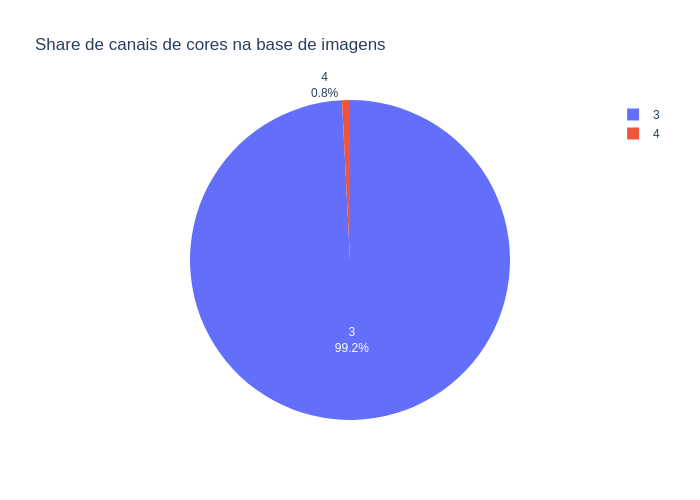

In [8]:
fig = px.pie(df_eda_images, values='source_channel', names='source_channel',  title='Share de canais de cores na base de imagens', labels={'source_channel': 'canal de cores'})
fig.update_traces(textinfo='percent+label')
# fig.show()
fig.show('png')

In [9]:
df_eda_images = df_eda_images.loc[df_eda_images['source_channel']==3].reset_index(drop=True)
df_eda_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Columns: 30775 entries, image_path to hist_r_255
dtypes: float64(30771), int64(1), object(3)
memory usage: 232.9+ MB


In [10]:
df_grouped =  df_eda_images.groupby(['source_width','source_height','label'])['image_path'].count().reset_index(name='count_shape')
df_eda_images = df_eda_images.merge(df_grouped, on=['source_width','source_height','label'], how='left')

,label_name,total_by_label,label,source_shape,source_height,source_width,source_channel,pixel0,pixel1,pixel2,...,hist_r_248,hist_r_249,hist_r_250,hist_r_251,hist_r_252,hist_r_253,hist_r_254,hist_r_255,count_shape,percent_by_label
0,Com fogo,752,752,752,752,752,752,752,752,752,...,752,752,752,752,752,752,752,752,752,75.81
1,Sem fogo,240,240,240,240,240,240,240,240,240,...,240,240,240,240,240,240,240,240,240,24.19


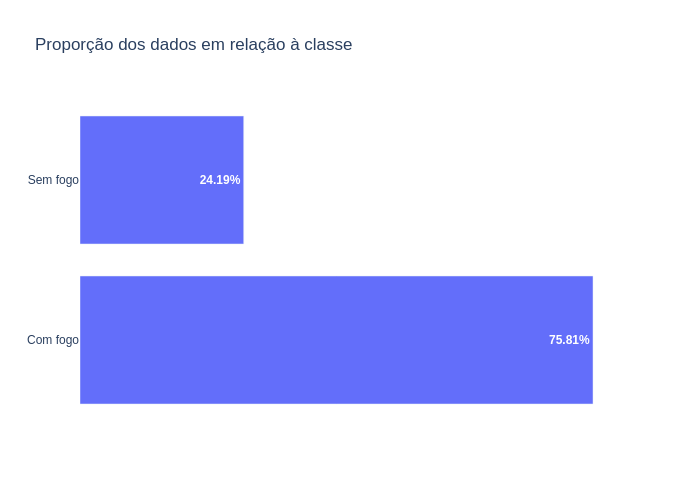

In [13]:
#@title Proporção dos dados em relação à classe
df_categories_proportion = df_eda_images.groupby('label_name').count().reset_index().rename(columns={'image_path':'total_by_label'})
df_categories_proportion['percent_by_label'] = round(df_categories_proportion['total_by_label']/df_categories_proportion['total_by_label'].sum() *100, 2)

display(df_categories_proportion)

fig = go.Figure([go.Bar(
    y=df_categories_proportion['label_name'], 
    x=df_categories_proportion['percent_by_label'],
    text=df_categories_proportion['percent_by_label'],
    textposition='auto',
    texttemplate="<b>%{text}%</b>",
    orientation='h',
)])
fig.update_xaxes(showticklabels=False)

fig.update_layout(
    title='Proporção dos dados em relação à classe',
    # paper_bgcolor='#fff',
    plot_bgcolor='#fff',
    font=dict(
        family="Arial",
        # size=30,
    )
)
# fig.show()
fig.show('png')

In [14]:
print('Quantidade de dimensões diferentes na base: ', len(df_eda_images['source_shape'].unique()))

Quantidade de dimensões diferentes na base:  599


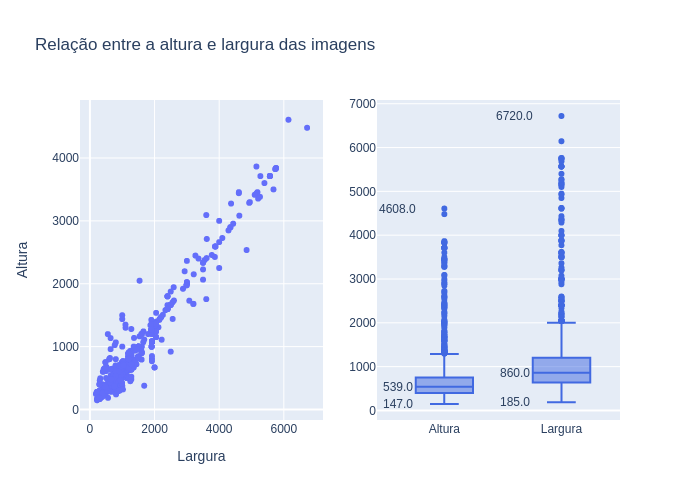

In [15]:
#@title

df_describe_eda = df_eda_images[['source_width','source_height']].describe()

fig = make_subplots(rows=1, cols=2) #, subplot_titles=("Scatterplot", "Boxplot"))
fig.add_trace(go.Scatter(
  x=df_eda_images['source_width'], 
  y=df_eda_images['source_height'], 
  mode='markers',
  showlegend=False
), row=1, col=1)

boxplot_info = [(-0.4, 'source_height', 'Altura'), (0.6, 'source_width', 'Largura')]
for x, field, label in boxplot_info:
  fig.add_trace(go.Box(y=df_eda_images[field], name=label, marker_color='royalblue', showlegend=False), row=1, col=2)
  for k in ['min', '50%', 'max']:      
    y = df_describe_eda.loc[k][field]
    fig.add_annotation(
      x=x, y=y, xref="x2", yref="y2", text=y,
      showarrow=False,
    )  
 
fig.update_layout(
    title='Relação entre a altura e largura das imagens',
    xaxis=dict(title='Largura'),
    yaxis=dict(title='Altura'),
    font=dict(
        family="Arial",
        # size=25
    ),
)
# fig.show()
fig.show('png')

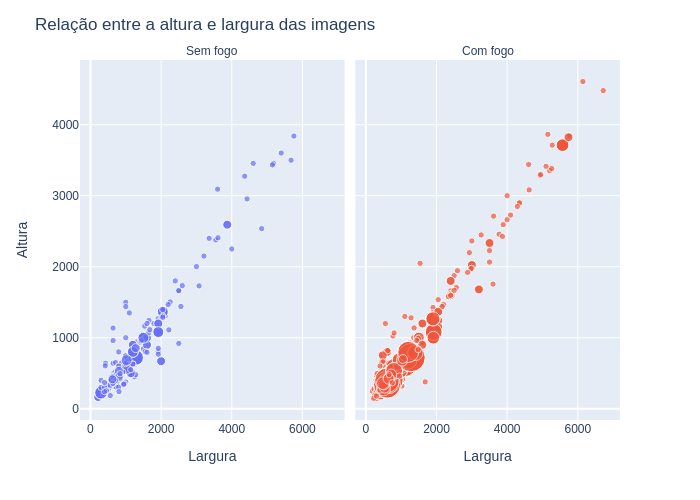

In [16]:
#@title
fig = px.scatter(df_eda_images, x="source_width", y="source_height", color="label_name",
                 size='count_shape', facet_col="label_name")

fig['layout']['xaxis']['title']='Largura'
fig['layout']['yaxis']['title']='Altura'
fig['layout']['xaxis2']['title']='Largura'
fig['layout']['yaxis2']['title']=''
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

fig.update_layout(
    title='Relação entre a altura e largura das imagens',
    # plot_bgcolor='#fff',
     font=dict(
        family="Arial",
        # size=16,
    ),
    showlegend=False
)
# fig.show()
fig.show('png')

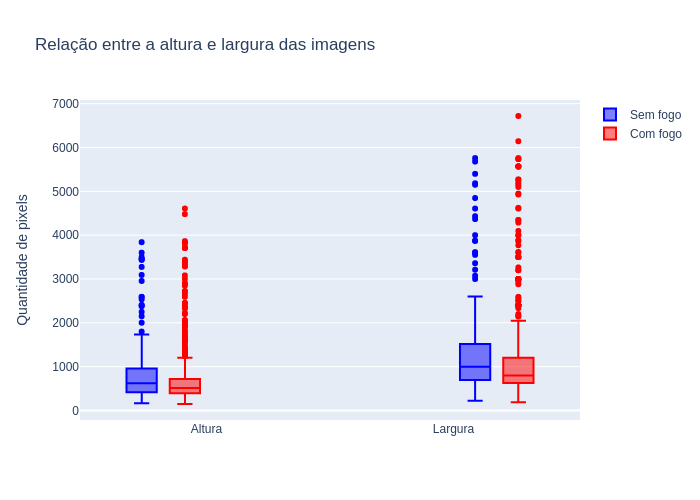

In [17]:
#@title
df_image_shapes_0 = df_eda_images.loc[df_eda_images['label']==0]
df_image_shapes_1 = df_eda_images.loc[df_eda_images['label']==1]
altura0 = ['Altura'] * len(df_image_shapes_0)
altura1 = ['Altura'] * len(df_image_shapes_1)

largura0 = ['Largura'] * len(df_image_shapes_0)
largura1 = ['Largura'] * len(df_image_shapes_1)
fig = go.Figure()
fig.add_trace(go.Box(y=df_image_shapes_0['source_height'], x=altura0, name='Sem fogo', marker_color='blue'))
fig.add_trace(go.Box(y=df_image_shapes_1['source_height'], x=altura1, name='Com fogo', marker_color='red'))

fig.add_trace(go.Box(y=df_image_shapes_0['source_width'], x=largura0, name='Sem fogo', marker_color='blue', showlegend=False))
fig.add_trace(go.Box(y=df_image_shapes_1['source_width'], x=largura1, name='Com fogo', marker_color='red', showlegend=False))
fig.update_layout(
    title='Relação entre a altura e largura das imagens',
    yaxis_title='Quantidade de pixels',
    boxmode='group' # group together boxes of the different traces for each value of x
)
# fig.show()
fig.show('png')

## Amostragem dos dados

In [ ]:
# Executar apenas uma vez para gerar a amostra de imagens

# df_sample = df_images[COLUMNS_PIXELS + ['label']].groupby('label').sample(n=5).copy().reset_index()
# df_sample.to_csv('{}sample.csv'.format(PREFIX_PATH), index=False)
# df_sample.head()

,index,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,label
0,33,4.0,63.0,15.0,81.0,134.0,91.0,3.0,9.0,4.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0
1,100,0.0,174.0,66.0,36.0,158.0,90.0,125.0,250.0,224.0,...,10.0,85.0,53.0,4.0,66.0,19.0,0.0,29.0,1.0,0
2,106,239.0,255.0,254.0,239.0,255.0,254.0,239.0,255.0,254.0,...,17.0,40.0,23.0,9.0,13.0,8.0,13.0,22.0,12.0,0
3,117,48.0,50.0,41.0,66.0,64.0,52.0,47.0,43.0,28.0,...,1.0,5.0,36.0,0.0,0.0,8.0,0.0,0.0,0.0,0
4,115,250.0,255.0,255.0,243.0,254.0,255.0,247.0,255.0,255.0,...,126.0,156.0,148.0,29.0,63.0,59.0,17.0,40.0,30.0,0


In [18]:
df_sample = pd.read_csv('{}sample.csv'.format(PREFIX_PATH))
df_sample.head()

,index,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,label
0,33,4.0,63.0,15.0,81.0,134.0,91.0,3.0,9.0,4.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0
1,100,0.0,174.0,66.0,36.0,158.0,90.0,125.0,250.0,224.0,...,10.0,85.0,53.0,4.0,66.0,19.0,0.0,29.0,1.0,0
2,106,239.0,255.0,254.0,239.0,255.0,254.0,239.0,255.0,254.0,...,17.0,40.0,23.0,9.0,13.0,8.0,13.0,22.0,12.0,0
3,117,48.0,50.0,41.0,66.0,64.0,52.0,47.0,43.0,28.0,...,1.0,5.0,36.0,0.0,0.0,8.0,0.0,0.0,0.0,0
4,115,250.0,255.0,255.0,243.0,254.0,255.0,247.0,255.0,255.0,...,126.0,156.0,148.0,29.0,63.0,59.0,17.0,40.0,30.0,0


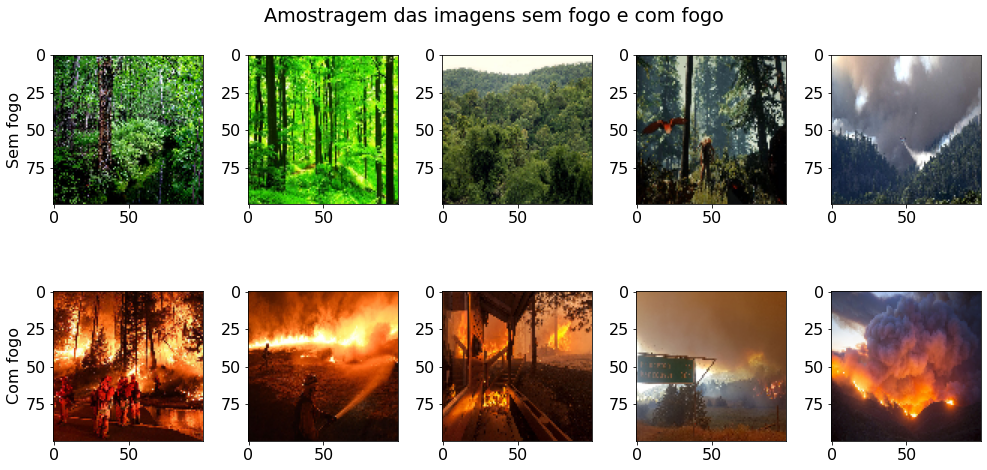

In [19]:
plt.rcParams.update({'font.size': 16})
figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(14, 7))
for i in range(0,10):
  image_flatten = df_sample.loc[i][COLUMNS_PIXELS].to_numpy(dtype='uint8')
  resized_image = image_flatten.reshape(RESIZE_X, RESIZE_Y, CHANNEL)
  image = resized_image
  ax.ravel()[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.suptitle('Amostragem das imagens sem fogo e com fogo')
plt.setp(ax[0, 0], ylabel='Sem fogo')
plt.setp(ax[1, 0], ylabel='Com fogo')
plt.tight_layout()
plt.show()

## Histogramas

In [20]:
def get_df_eda_histograms(df, label=None):
  if label is not None:
    df_aux = pd.DataFrame(df.loc[df['label']==label][HIST_COLUMNS]).reset_index(drop=True)
    df_describe = df_aux.describe()
  else:
    df_describe = df[HIST_COLUMNS].describe()
  
  return df_describe

In [21]:
df_eda_0 = get_df_eda_histograms(df_images, 0)
df_eda_1 = get_df_eda_histograms(df_images, 1)
df_eda_hist = get_df_eda_histograms(df_images, None)
df_eda_hist

,hist_b_0,hist_b_1,hist_b_2,hist_b_3,hist_b_4,hist_b_5,hist_b_6,hist_b_7,hist_b_8,hist_b_9,...,hist_r_246,hist_r_247,hist_r_248,hist_r_249,hist_r_250,hist_r_251,hist_r_252,hist_r_253,hist_r_254,hist_r_255
count,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,...,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000
mean,11.432460,6.463710,5.784274,4.492944,3.775202,3.339718,3.206653,2.956653,2.826613,2.552419,...,0.484879,0.594758,0.527218,0.539315,0.637097,0.742944,0.752016,1.133065,1.420363,2.950605
std,34.297233,13.419592,11.444678,9.085975,7.475278,6.381934,6.991608,6.490476,5.774625,5.186460,...,1.726441,3.104486,1.777555,1.775624,2.617059,2.931345,2.645369,5.854305,7.595853,15.683119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,6.000000,6.000000,6.000000,4.000000,4.000000,4.000000,4.000000,3.250000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,300.000000,172.000000,93.000000,71.000000,60.000000,48.000000,83.000000,103.000000,69.000000,57.000000,...,27.000000,78.000000,24.000000,18.000000,56.000000,56.000000,43.000000,135.000000,183.000000,300.000000


In [22]:
#@title Funções de plot do histograma

plt.rcParams.update({'font.size': 16})
def plot_diff_histogram_bgr_plotly(df_0, df_1, field, title):
  b = (df_0[COLUMNS_HIST_B].loc[field] - df_1[COLUMNS_HIST_B].loc[field]).to_list()
  g = (df_0[COLUMNS_HIST_G].loc[field] - df_1[COLUMNS_HIST_G].loc[field]).to_list()
  r = (df_0[COLUMNS_HIST_R].loc[field] - df_1[COLUMNS_HIST_R].loc[field]).to_list()
  x = np.arange(0, 255, 1, dtype=int)

  fig = go.Figure()  
  for y, name, color in [(b, 'Azul', 'Blue'), (g, 'Verde', 'green'), (r, 'Vermelho', 'Red')]:
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=name, marker_color=color, showlegend=False))

  fig.update_layout(
    title=title,
    # paper_bgcolor='#fff',
    plot_bgcolor='#fff',
    font=dict(
        family="Arial",
        # size=30,
    )
  )
  # fig.show()
  fig.show('png')

def plot_diff_histogram_bgr_plotly_2plots(df_0, df_1, title):
  x = np.arange(0, 255, 1, dtype=int)
  values = [
    (COLUMNS_HIST_B, 'mean', 'Azul', 'Blue', 1), 
    (COLUMNS_HIST_G, 'mean', 'Verde', 'green', 1), 
    (COLUMNS_HIST_R, 'mean', 'Vermelho', 'Red', 1), 
    (COLUMNS_HIST_B, 'std', 'Azul', 'Blue', 2), 
    (COLUMNS_HIST_G, 'std', 'Verde', 'green', 2), 
    (COLUMNS_HIST_R, 'std', 'Vermelho', 'Red', 2)
  ]

  fig = make_subplots(rows=1, cols=2, subplot_titles=("Média", "Desvio Padrão"))
  for columns, field, name, color, col in values:
    y = (df_0[columns].loc[field] - df_1[columns].loc[field]).to_list()
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=name, marker_color=color, showlegend=True), row=1, col=col)

  fig.update_layout(
    title=title,
    # paper_bgcolor='#fff',
    plot_bgcolor='#fff',
    font=dict(
        family="Arial",
        # size=20,
    )
  )
  # fig.show()
  fig.show('png')

def plot_diff_histogram_bgr_plotly_2plots2(df_0, df_1, title):
  x = np.arange(0, 255, 1, dtype=int)
  values = [
    (COLUMNS_HIST_B, 'mean', 'Azul', 'Blue', 1), 
    (COLUMNS_HIST_G, 'mean', 'Verde', 'green', 1), 
    (COLUMNS_HIST_R, 'mean', 'Vermelho', 'Red', 1), 
    (COLUMNS_HIST_B, 'std', 'Azul', 'Blue', 2), 
    (COLUMNS_HIST_G, 'std', 'Verde', 'green', 2), 
    (COLUMNS_HIST_R, 'std', 'Vermelho', 'Red', 2)
  ]

  fig = make_subplots(rows=1, cols=2, subplot_titles=("Média", "Desvio Padrão"))
  for columns, field, name, color, col in values:
    y = (df_0[columns].loc[field] - df_1[columns].loc[field]).to_list()
    # fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=name, marker_color=color, showlegend=True), row=1, col=col)
    fig.add_trace(go.Histogram(x=x, y=y, name=name, marker_color=color, showlegend=True), row=1, col=col)

  fig.update_layout(
    title=title,
    barmode='overlay',
    # paper_bgcolor='#fff',
    plot_bgcolor='#fff',
    font=dict(
        family="Arial",
        # size=20,
    )
  )
  fig.update_traces(opacity=0.75)
  # fig.show()
  fig.show('png')

def plot_histogram_bgr_matplotlib_2plots(df, title):
  fig = plt.figure(figsize=(18, 5))
  grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.3)

  ax1 = fig.add_subplot(grid[0, 0])
  ax2 = fig.add_subplot(grid[0, 1])

  values = [
    (COLUMNS_HIST_B, 'mean', 'b', 'Média', ax1), 
    (COLUMNS_HIST_G, 'mean', 'g', 'Média', ax1), 
    (COLUMNS_HIST_R, 'mean', 'r', 'Média', ax1), 
    (COLUMNS_HIST_B, 'std',  'b', 'Desvio Padrão', ax2), 
    (COLUMNS_HIST_G, 'std',  'g', 'Desvio Padrão', ax2), 
    (COLUMNS_HIST_R, 'std',  'r', 'Desvio Padrão', ax2)
  ] 

  for columns, field, color, subtitle, ax in values:
    y = (df[columns].loc[field]).to_list()
    ax.plot(y, color=color)
    ax.set_title(subtitle)
    ax.set_xlim([0,260]) 
  
  
  plt.suptitle(title)
  # plt.show()
  fig.show('png')

def plot_diff_histogram_bgr_matplotlib_2plots(df_0, df_1, title):
  fig = plt.figure(figsize=(18, 5))
  grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.3)

  ax1 = fig.add_subplot(grid[0, 0])
  ax2 = fig.add_subplot(grid[0, 1])

  values = [
    (COLUMNS_HIST_B, 'mean', 'b', 'Média', ax1), 
    (COLUMNS_HIST_G, 'mean', 'g', 'Média', ax1), 
    (COLUMNS_HIST_R, 'mean', 'r', 'Média', ax1), 
    (COLUMNS_HIST_B, 'std',  'b', 'Desvio Padrão', ax2), 
    (COLUMNS_HIST_G, 'std',  'g', 'Desvio Padrão', ax2), 
    (COLUMNS_HIST_R, 'std',  'r', 'Desvio Padrão', ax2)
  ] 

  for columns, field, color, subtitle, ax in values:
    y = (df_0[columns].loc[field] - df_1[columns].loc[field]).to_list()
    ax.plot(y, color=color)
    ax.set_title(subtitle)
    ax.set_xlim([0,260]) 
  
  
  plt.suptitle(title)
  # plt.show()
  fig.show('png')

def plot_diff_histogram_bgr(df_0, df_1, field, title):
  b = (df_0[COLUMNS_HIST_B].loc[field] - df_1[COLUMNS_HIST_B].loc[field]).to_list()
  g = (df_0[COLUMNS_HIST_G].loc[field] - df_1[COLUMNS_HIST_G].loc[field]).to_list()
  r = (df_0[COLUMNS_HIST_R].loc[field] - df_1[COLUMNS_HIST_R].loc[field]).to_list()

  fig = plt.figure(figsize=(12, 5))
  plt.plot(b, color='b')
  plt.plot(g, color='g')
  plt.plot(r, color='r')
  plt.xlim([0,256])
  plt.title(title)
  # plt.show()
  fig.show('png')

def plot_single_histogram_bgr(b, g, r, title):
  fig = plt.figure(figsize=(12, 5))
  plt.plot(b, color='b')
  plt.plot(g, color='g')
  plt.plot(r, color='r')
  plt.xlim([0,256])
  plt.title(title)
  plt.show()


def plot_3_histogram(df_0, df_1, field, title, title_0, title_1, title_2):
  fig = plt.figure(figsize=(18, 10))
  grid = plt.GridSpec(2, 2)#, wspace=0.1, hspace=0.3)

  ax1 = fig.add_subplot(grid[0, 0])
  ax2 = fig.add_subplot(grid[0, 1])
  ax3 = fig.add_subplot(grid[1,:])

  ax1.plot(df_0[COLUMNS_HIST_B].loc[field].to_list(), color='b')
  ax1.plot(df_0[COLUMNS_HIST_G].loc[field].to_list(), color='g')
  ax1.plot(df_0[COLUMNS_HIST_R].loc[field].to_list(), color='r')
  
  ax2.plot(df_1[COLUMNS_HIST_B].loc[field].to_list(), color='b')
  ax2.plot(df_1[COLUMNS_HIST_G].loc[field].to_list(), color='g')
  ax2.plot(df_1[COLUMNS_HIST_R].loc[field].to_list(), color='r')

  b = (df_0[COLUMNS_HIST_B].loc[field] - df_1[COLUMNS_HIST_B].loc[field]).to_list()
  g = (df_0[COLUMNS_HIST_G].loc[field] - df_1[COLUMNS_HIST_G].loc[field]).to_list()
  r = (df_0[COLUMNS_HIST_R].loc[field] - df_1[COLUMNS_HIST_R].loc[field]).to_list()

  ax3.plot(b, color='b')
  ax3.plot(g, color='g')
  ax3.plot(r, color='r')
  
  plt.xlim([0,256])
  ax1.set_title(title_0)
  ax2.set_title(title_1)
  ax3.set_title(title_2)
  
  ymin = min(df_0.loc[field].to_list() +  df_1.loc[field].to_list())
  ymax = max(df_0.loc[field].to_list() +  df_1.loc[field].to_list())

  ax1.set_ylim([ymin, ymax])
  ax2.set_ylim([ymin, ymax])

  plt.suptitle(title)
  # plt.show()
  fig.show('png')

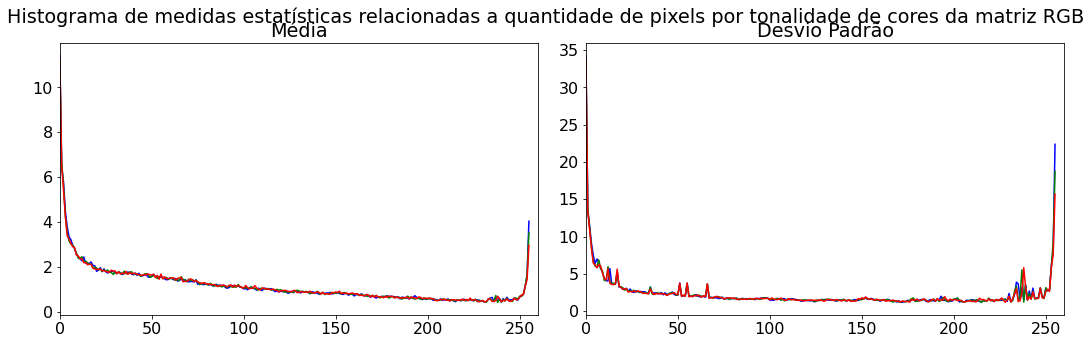

In [24]:
#@title Histograma de medidas estatísticas relacionadas a quantidade de pixels por tonalidade de cores da matriz RGB

# plot_histogram_bgr_matplotlib_2plots(df_eda_hist, '')
plot_histogram_bgr_matplotlib_2plots(df_eda_hist, 'Histograma de medidas estatísticas relacionadas a quantidade de pixels por tonalidade de cores da matriz RGB')

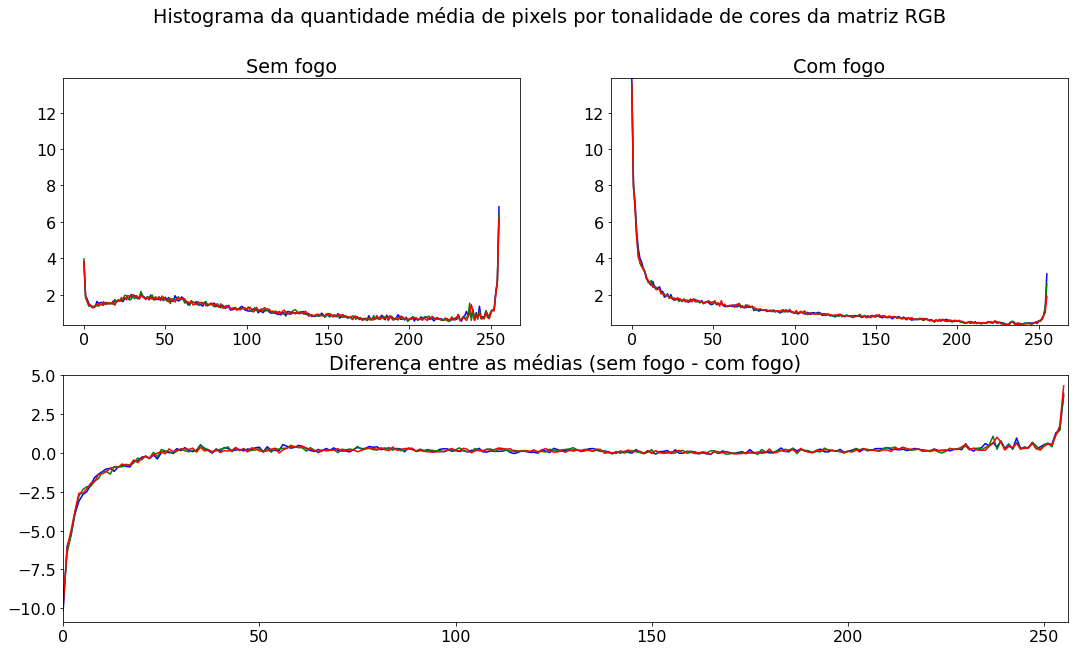

In [25]:
#@title Histograma da quantidade média de pixels por tonalidade de cores da matriz RGB

plot_3_histogram(
    df_eda_0, 
    df_eda_1, 
    'mean', 
    'Histograma da quantidade média de pixels por tonalidade de cores da matriz RGB', 
    'Sem fogo',  
    'Com fogo',
    'Diferença entre as médias (sem fogo - com fogo)'
)

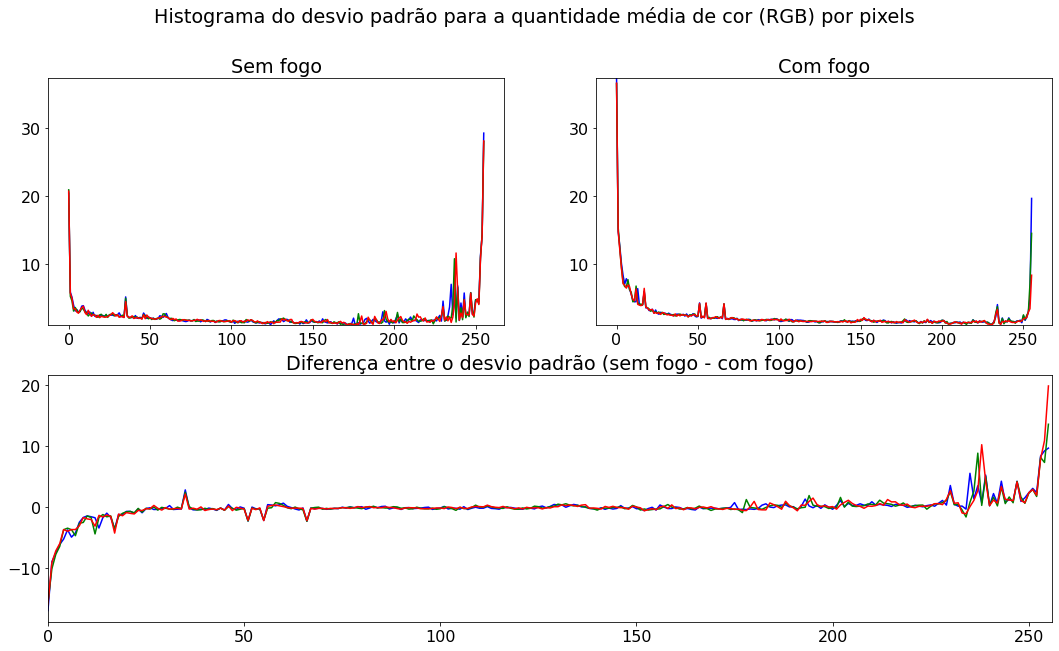

In [ ]:
#@title Histograma do desvio padrão para a quantidade de pixels por tonalidade de cores da matriz RGB
plot_3_histogram(
    df_eda_0, 
    df_eda_1, 
    'std', 
    'Histograma do desvio padrão para a quantidade de pixels por tonalidade de cores da matriz RGB',
    'Sem fogo',  
    'Com fogo',
    'Diferença entre o desvio padrão (sem fogo - com fogo)'
)

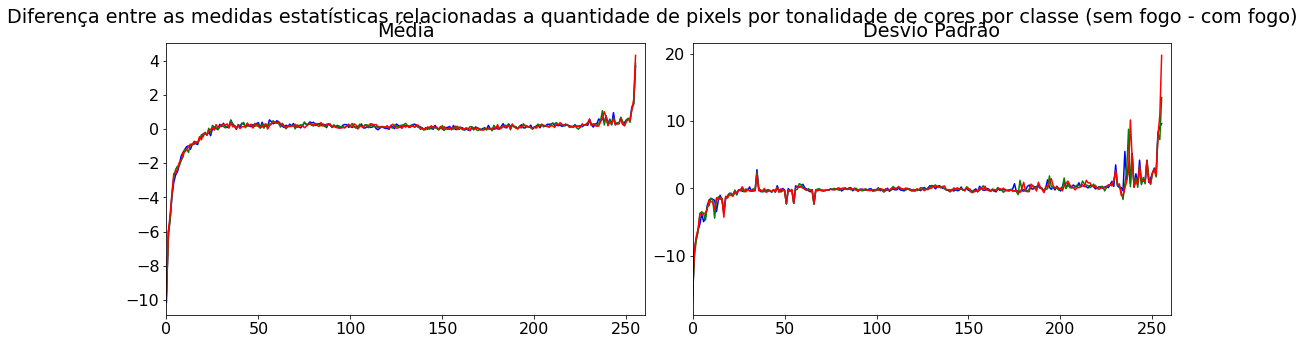

In [29]:
#@title Diferença entre as medidas estatísticas relacionadas a quantidade de pixels por tonalidade de cores por classe (sem fogo - com fogo)
plot_diff_histogram_bgr_matplotlib_2plots(df_eda_0, df_eda_1, 'Diferença entre as medidas estatísticas relacionadas a quantidade de pixels por tonalidade de cores por classe (sem fogo - com fogo)')
# print()
# plot_diff_histogram_bgr_plotly_2plots(df_eda_0, df_eda_1, 'Diferença entre as medidas estatísticas relacionadas a quantidade de pixels por tonalidade de cores por classe (sem fogo - com fogo)')

# Retorna conjunto de treinamento, validação e teste

In [30]:
#@title get_df_train_test
def get_df_train_test(prefix_path, df=None, split=True):
  if split:
    df_train, df_test = train_test_split(df, test_size=0.20, stratify=df['label'])   
    df_train.to_csv('{}train_images.csv'.format(prefix_path), index=False)
    df_test.to_csv('{}test_images.csv'.format(prefix_path), index=False)
  else:
    df_train = pd.read_csv('{}train_images.csv'.format(prefix_path))
    df_test = pd.read_csv('{}test_images.csv'.format(prefix_path))
  return df_train, df_test

# df_train, df_test = get_df_train_test(prefix_path=PREFIX_PATH, df=df_images)
df_train, df_test = get_df_train_test(prefix_path=PREFIX_PATH, split=False)

In [31]:
print(df_train.shape)
print(df_test.shape)

(793, 30775)
(199, 30775)


In [32]:
#@title Proporção dos dados em relação à classe por conjunto de dados
df_categories_proportion_train = df_train.groupby('label')['image_path'].count().reset_index().rename(columns={'image_path':'total_by_label'})
df_categories_proportion_train['percent_by_label'] = round(df_categories_proportion_train['total_by_label']/df_categories_proportion_train['total_by_label'].sum() *100, 2)
display(df_categories_proportion_train)

df_categories_proportion_test = df_test.groupby('label')['image_path'].count().reset_index().rename(columns={'image_path':'total_by_label'})
df_categories_proportion_test['percent_by_label'] = round(df_categories_proportion_test['total_by_label']/df_categories_proportion_test['total_by_label'].sum() *100, 2)
display(df_categories_proportion_test)

,label,total_by_label,percent_by_label
0,0,192,24.21
1,1,601,75.79


,label,total_by_label,percent_by_label
0,0,48,24.12
1,1,151,75.88


# Data albumentation e adição de ruído

Demo oficial da lib data albumentation: https://albumentations-demo.herokuapp.com/

In [33]:
#@title get_one_of_albumentation
def get_one_of_albumentation(image, p_t1=0.5, p_t2=0.5):  
  transform = A.Compose([                         
    A.OneOf([        
        A.RandomCrop(p=1.0, width=100, height=100),
        A.ShiftScaleRotate(p=1.0, shift_limit=(-0.06, 0.06), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-90, 90), interpolation=0, border_mode=0),
        A.OpticalDistortion(p=1.0, distort_limit=(-0.3, 0.3), shift_limit=(-0.05, 0.05), interpolation=0, border_mode=0),
        A.GridDistortion(p=1.0, num_steps=5, distort_limit=(-0.30000001192092896, 0.30000001192092896), interpolation=0, border_mode=0),
        A.Flip(p=1.0),
        A.ElasticTransform(p=1.0, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=0, approximate=False),
        A.Cutout(p=0.5, num_holes=10, max_h_size=5, max_w_size=5),
    ], p=p_t1),
    A.OneOf([
        A.RGBShift(p=1.0, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
        A.HueSaturationValue(p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
        A.ChannelShuffle(p=1.0),
        A.CLAHE(p=1.0, clip_limit=(1, 4), tile_grid_size=(8, 8)),
        A.RandomBrightnessContrast(p=1.0, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
        A.Blur(p=1.0, blur_limit=(3, 7)),
        A.ToGray(p=1.0),
        A.JpegCompression(p=1.0, quality_lower=10, quality_upper=50),
        A.InvertImg(p=1.0),
    ], p=p_t2),    
  ], p=1)

  augmented_image = transform(image=image)['image']
  return augmented_image.flatten().tolist()


def get_one_of_noise(image):
  noise_mode = random.choice(NOISES)
  noised_image = skimage.util.random_noise(image, mode=noise_mode, seed=100)
  return noised_image.flatten().tolist()

In [34]:
#@title get_albumentations_and_noises

def get_albumentations_and_noises(df, main_columns=['image_path', 'label', 'label_name']):
  albumentations = []
  noises = []
  for index, row in df.iterrows():
    image_flatten = row[COLUMNS_PIXELS].to_numpy(dtype='uint8')
    image = image_flatten.reshape(RESIZE_X, RESIZE_Y, CHANNEL)

    augmented_image_pixels = get_one_of_albumentation(image, 0.5, 0.5)
    noised_image_pixels = get_one_of_noise(image)
    
    albumentations.append(augmented_image_pixels)
    noises.append(noised_image_pixels)

  df_albumentations = pd.DataFrame(albumentations, columns=COLUMNS_PIXELS, index=df[main_columns].index)
  df_albumentations['pre_process_type'] = 'Albumentation'
  df_albumentations = pd.concat([df[main_columns], df_albumentations], axis=1)

  df_noises = pd.DataFrame(noises, columns=COLUMNS_PIXELS, index=df[main_columns].index)
  df_noises['pre_process_type'] = 'Noise'
  df_noises = pd.concat([df[main_columns], df_noises], axis=1)

  # df_albumentations_noises = pd.concat([df_albumentations, df_noises], ignore_index=True)
  return df_albumentations, df_noises

In [35]:
#@title Run albumentation

main_columns = ['image_path', 'label', 'label_name']
columns = main_columns + COLUMNS_PIXELS

df_train_1 = df_train.loc[df_train['label']==1][columns].copy()
df_train_1['pre_process_type'] = 'Original'

df_train_0 = df_train.loc[df_train['label']==0][columns].copy()
df_train_0['pre_process_type'] = 'Original'

# Execute apenas uma vez para gerar ruídos e albumentations, depois disso apenas leia os arquivos
# df_albumentations, df_noises = get_albumentations_and_noises(df_train_0)
# df_albumentations.to_csv('{}train_images_albumentation.csv'.format(PREFIX_PATH), index=False)
# df_noises.to_csv('{}train_images_noise.csv'.format(PREFIX_PATH), index=False)

df_albumentations = pd.read_csv('{}train_images_albumentation.csv'.format(PREFIX_PATH))
df_noises = pd.read_csv('{}train_images_noise.csv'.format(PREFIX_PATH))

df_train_aux = pd.concat([df_train_0, df_albumentations, df_noises, df_train_1], ignore_index=True).sort_values(['label', 'image_path', 'pre_process_type'], ascending = [True, True, False]).reset_index(drop=True)
display(df_train_aux.head(3))
display(df_train_aux.tail(3))

,image_path,label,label_name,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,pre_process_type
0,fire_dataset/non_fire_images/non_fire.1.png,0,Sem fogo,200.000000,200.000000,200.000000,201.000000,201.0,201.000000,200.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Original
1,fire_dataset/non_fire_images/non_fire.1.png,0,Sem fogo,0.784314,0.784314,0.784314,0.788235,0.0,0.788235,0.784314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Noise
2,fire_dataset/non_fire_images/non_fire.1.png,0,Sem fogo,200.000000,200.000000,200.000000,201.000000,201.0,201.000000,200.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Albumentation


,image_path,label,label_name,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,pre_process_type
1174,fire_dataset/fire_images/fire.96.png,1,Com fogo,155.0,149.0,135.0,189.0,184.0,163.0,105.0,...,13.0,28.0,31.0,98.0,123.0,137.0,122.0,138.0,153.0,Original
1175,fire_dataset/fire_images/fire.97.png,1,Com fogo,128.0,126.0,137.0,208.0,202.0,195.0,190.0,...,34.0,32.0,32.0,79.0,77.0,76.0,46.0,47.0,57.0,Original
1176,fire_dataset/fire_images/fire.99.png,1,Com fogo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,2.0,41.0,1.0,8.0,47.0,0.0,7.0,43.0,Original


In [36]:
df_categories_proportion_train_aux1 = df_train_aux.groupby('label')['image_path'].count().reset_index().rename(columns={'image_path':'total_by_label'})
df_categories_proportion_train_aux1['percent_by_label'] = round(df_categories_proportion_train_aux1['total_by_label']/df_categories_proportion_train_aux1['total_by_label'].sum() *100, 2)
display(df_categories_proportion_train_aux1)

,label,total_by_label,percent_by_label
0,0,576,48.94
1,1,601,51.06


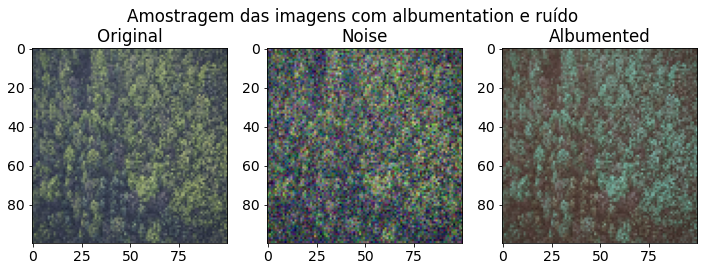

In [37]:
#@title Amostragem das imagens com albumentation e ruído

df_train_aux0 = pd.concat([df_train_0, df_albumentations, df_noises], ignore_index=True).sort_values(['label', 'image_path', 'pre_process_type'], ascending = [True, True, False]).reset_index(drop=True)
df_albumented_sample = df_train_aux0.loc[570:572].reset_index(drop=True)


plt.rcParams.update({'font.size': 14})
figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
for i in range(0,3):
  if df_albumented_sample.loc[i]['pre_process_type'] == 'Noise':
    image_flatten = df_albumented_sample.loc[i][COLUMNS_PIXELS].to_numpy(dtype='float32')
  else:  
    image_flatten = df_albumented_sample.loc[i][COLUMNS_PIXELS].to_numpy(dtype='uint8')
  
  resized_image = image_flatten.reshape(RESIZE_X, RESIZE_Y, CHANNEL)
  image = resized_image
  ax.ravel()[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.suptitle('Amostragem das imagens com albumentation e ruído')
ax[0].set_title('Original')
ax[1].set_title('Noise')
ax[2].set_title('Albumented')
plt.tight_layout()
plt.show()